In [1]:
import requests
import json
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from datetime import datetime
from datetime import timedelta
from fabric import Connection
import psycopg2
import gmaps
import pandas.io.sql as sqlio
import getpass
from io import StringIO
import paramiko
import sys
from time import sleep
from tqdm import tqdm

sys.path.insert(0, "/home/jovyan/watexr/PROGNOS/")
from prognos_tools.gce_light import gce_api as gce

key = getpass.getpass('mobiserver password: ')
cloudKey = getpass.getpass('vault password: ')
#Querying necessary tokens
def query(query,fetch=True):
    with psycopg2.connect(user='jose-luis', host='mobiserver.niva.no', port=5432, database='vault',password=key) as db:
        with db.cursor() as cursor :
            if fetch:
                return sqlio.read_sql_query(query, db)
            else :
                cursor.execute(query)
            
# def insertFile(alias,filename):
#     with psycopg2.connect(user='jose-luis', host='mobiserver.niva.no', port=5432, database='vault',password=key) as db:
#         with db.cursor() as cursor :
#             cursor.execute('drop table if exists dummy;')
#             cursor.execute('''create temp table dummy (sometext bytea);''')
#             with open(filename,'rb') as f:
# #                 cursor.copy_from(f,'dummy')
#                 cursor.execute('''insert into dummy  select %s::bytea;''',(psycopg2.Binary(f.read()),) )
#             cursor.execute('''select niva.insertToken('{}',(select * from dummy),'');'''.format(alias));

gmapsKey = query('''select niva.getToken('gmaps','{}');'''.format(cloudKey)).iloc[0,0]
sshKey = query('''select niva.getToken('geonorway_ssh_key','{}');'''.format(cloudKey)).iloc[0,0]
nveKey = query('''select niva.getToken('nveKey','{}');'''.format(cloudKey)).iloc[0,0]
cloudKey = json.loads(query('''select niva.getToken('gce_access','{}');'''.format(cloudKey)).iloc[0,0])
gmaps.configure(gmapsKey)
not_really_a_file = StringIO(sshKey)
private_key = paramiko.RSAKey.from_private_key(not_really_a_file)
del key,sshKey

mobiserver password:  ·······
vault password:  ···············


In [2]:
#Check status of instance
properties = {'project'      : 'nivacatchment',
             'zone'         : 'europe-north1-a',
             'instanceType' : "n1-standard-4",
             'instanceName' : "dtm10",
             'username'     : "jose-luis",
             }

cloud = gce(properties, cloudKey)
del cloudKey

In [3]:
#Getting instance info
cloud.CommonCalls['custom'] = '''https://compute.googleapis.com/compute/v1/projects/{project}/zones/{zone}/instances/{instanceName}'''
info = cloud.get('custom')
display(info['status'])
#If instance is stopped, start it
if info['status'] != 'RUNNING':
    cloud.CommonCalls['custom'] = '''https://compute.googleapis.com/compute/v1/projects/{project}/zones/{zone}/instances/{instanceName}/start'''
    info = cloud.post('custom')
    display(info['status'])
    cloud.CommonCalls['custom'] = '''https://compute.googleapis.com/compute/v1/projects/{project}/zones/{zone}/instances/{instanceName}'''
    info = cloud.get('custom')
    while info['status'] != 'RUNNING':
           sleep(2)
           info = cloud.get('custom')
          
geonorway = info['networkInterfaces'][0]['accessConfigs'][0]['natIP']    
    
display(geonorway)
config =  {'host' : geonorway, 'user': 'jose-luis', 'connect_kwargs': {'pkey': private_key } }

def query(query,fetch=True):
    with psycopg2.connect(user='jose-luis', host=geonorway, port=5432, database='geonorway') as db:
        cursor = db.cursor()
        if fetch:
            return sqlio.read_sql_query(query, db)
        else :
            cursor.execute(query)
        

'RUNNING'

'35.228.143.19'

# Getting basin boundaries

In [4]:
schema='catchcan'
#Getting basins boundaries
a = query('''SELECT json_build_object('type', 'FeatureCollection',
                                      'features', json_agg(json_build_object(
                                                                'type',       'Feature',
                                                                'label',      b.stationname,
                                                                'geometry',   ST_AsGeoJSON(ST_ForceRHR(St_Transform(a.geom,4326)))::json,
                                                                'properties', jsonb_set(row_to_json(a)::jsonb,'{{a.geom}}','0',false)
                                                                )
                                                            )
                                     )
             FROM {0}.basinsdtm1 as a join {0}.outlet_1m as b on b.sid=a.sid;'''.format(schema))

fig = gmaps.figure(map_type="TERRAIN")
fig.add_layer(gmaps.geojson_layer(a.iloc[0,0]))

b = query('''SELECT a.stationname, st_x(st_transform(a.geom,4326)),
    st_y(st_transform(a.geom,4326)), c.area/1e6 as area, a.sid
    FROM {0}.outlet_1m AS a
    JOIN {0}.basinsdtm1 as c
    on a.sid=c.sid
'''.format(schema))


outlets = [{"name": i[0], "area": i[3], "id": i[4]} for j,i in b.iterrows()]
locations = [(float(i[2]),float(i[1])) for j,i in b.iterrows()]
info_box_template = """
<dl>
<font color="black">
<dt>Name</dt><dd>{name}</dd>
<dt>Id</dt><dd>{id}</sup></dd>
<dt>Area</dt><dd>{area} km<sup>2</sup></dd>
</font>
</dl>
"""                                                
outlet_info = [info_box_template.format(**outlet) for outlet in outlets]                                                 
marker_layer = gmaps.marker_layer(locations, info_box_content=outlet_info)
fig.add_layer(marker_layer)

fig

Figure(layout=FigureLayout(height='420px'))

## Finding out which cells in the era5 data intersect with the basins

In [5]:
sql = '''drop table if exists geographybasins;
create temp table geographybasins as select sid, st_transform(geom,4326)::geography as geom from catchcan.basinsdtm1;
create index temp_idx_geom on geographybasins using gist(geom);
drop table if exists getera5data;
create temp table getera5data as select b.sid as basinid,a.*, st_area(st_intersection(a.geom,b.geom))/st_area(b.geom) as weight from era5.location as a, geographybasins as b where st_intersects(a.geom,b.geom);
select * from getera5data;'''.format(schema=schema)

a = query(sql)
a

,basinid,sid,idx,row,col,geom,point,weight
0,2,18550,18549,99,90,0103000020E61000000100000005000000000000000040...,0101000020E6100000F6285C8FC2F5B83F5C8FC2F5285C...,0.068551
1,2,18755,18754,99,91,0103000020E61000000100000005000000000000000040...,0101000020E6100000F6285C8FC2F5B83F48E17A14AE47...,0.931449
2,1,20184,20183,93,98,0103000020E61000000100000005000000000000000040...,0101000020E61000001F85EB51B81EB53FB81E85EB51B8...,1.000000


## Showing the available variables in the era5 dataset and the time interval for which they are available

In [37]:
#Getting the variables from the era5 dataset
#Showing available datasets
attributes = query('''select * from era5.attributes;''')
fechas = query('''select * from era5.time order by fecha;''')
fechas.set_index('tid',inplace=True)
display(attributes,fechas)

,aid,name,unit,longname
0,1,u10,m s**-1,10 metre U wind component
1,2,v10,m s**-1,10 metre V wind component
2,3,d2m,K,2 metre dewpoint temperature
3,4,t2m,K,2 metre temperature
4,5,cdir,J m**-2,Clear-sky direct solar radiation at surface
5,6,msl,Pa,Mean sea level pressure
6,7,msdwlwrfcs,W m**-2,Mean surface downward long-wave radiation flux...
7,8,msdwswrfcs,W m**-2,Mean surface downward short-wave radiation flu...
8,9,pev,m,Potential evaporation
9,10,tcc,(0 - 1),Total cloud cover


,fecha
tid,
352609,1979-01-01 00:00:00+00:00
352610,1979-01-01 01:00:00+00:00
352611,1979-01-01 02:00:00+00:00
352612,1979-01-01 03:00:00+00:00
352613,1979-01-01 04:00:00+00:00
...,...
19964,2021-03-24 19:00:00+00:00
19965,2021-03-24 20:00:00+00:00
19966,2021-03-24 21:00:00+00:00


## Reading from the database containing the ERA5 dataset
This database contains a schema called era5 which contains the following tables:
1. era5.variables -> each line indexes to a timestamp, a variable , an encoding and contains a bytea field with the variable values. This query extracts and decodes from the bytea for certain indexes. It transforms bytea to int2 and this required a hack to be able to do it inline.
1. era5.encoding -> the encoding for each variable at each timestep. Relates to era5.variables on eid
1. era5.variables -> lists all the variables available in the dataset. Relates to era5.variables on aid
1. era5.time -> lists all the timestamps for which there are data. Relates to era5.variables on tid

This query consumes a significant amount of resources. If it takes more than a few minutes to get data for all timesteps for a single variable at a single coordinate, it is probably stuck and you're gonna die waiting for it to complete. In that case either increase temp_buffers and work_mem or try chunking the query. If it is the first time you query a particular variable, it might take around an hour.

Fist we give an example of how to download t2m for all timesteps at all stations. 

In [40]:
%%time
#Finding the intersection between the basins and the era5 dataset
sql = '''
--This query is pretty heavy so we increase the available memory
--If it is still slow, try increasing this. Otherwise chunk your queries
SET temp_buffers='4000MB';
SET work_mem='4000MB';

--Transforming the basins to the same coordinate system as the era5 data
drop table if exists geographybasins;
create temp table geographybasins as select sid, st_transform(geom,4326)::geography as geom from {schema}.basinsdtm1;
create index temp_idx_geom on geographybasins using gist(geom);

drop table if exists getera5data;
create temp table getera5data as
with dummy as (
--Finding intersection between era5 data and the basins
select b.sid as basinid,a.idx, st_area(st_intersection(a.geom,b.geom))/st_area(b.geom)::double precision as weight 
from era5.location as a, 
geographybasins as b 
where 
st_intersects(a.geom,b.geom)
)
select b.fecha,a.basinid, a.weight,
    case 
		when 
		--horrible hack to cast a bytea column containing int2 values to int2 -> this casts the binary representation of int2 to int2
			(((get_byte(substring(c.val from a.idx*2 + 2 for 1),0)::bit(8) ||  get_byte(substring(c.val from a.idx*2 for 1),0)::bit(8))::bit(32)::int4)>>16)::int2 = d.novalue
		then null::double precision
		else
		-- horrible hack it depends on the endianness of the system. Might fail horribly
			((((get_byte(substring(c.val from a.idx*2 + 2  for 1),0)::bit(8) ||  get_byte(substring(c.val from a.idx*2  for 1),0)::bit(8))::bit(32)::int4)>>16)::double precision 
            * d.scalefactor + d.addoffset) * a.weight  
	end as val
from dummy as a, 
era5.time as b 
join era5.variables as c on c.tid=b.tid and c.aid={aid}
join era5.encoding as d
on d.eid=c.eid
order by b.fecha,a.basinid;

reset temp_buffers;
reset work_mem;

select fecha, basinid, sum(val) as val from getera5data group by fecha,basinid order by fecha,basinid;
--select * from getera5data;

'''

a = query(sql.format(schema=schema,aid=4))


CPU times: user 3.33 s, sys: 168 ms, total: 3.5 s
Wall time: 29.2 s


In [34]:
a.set_index(['fecha','basinid']).unstack(level=1).plot(subplots=True,figsize=(15,10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:xlabel='fecha'>, <AxesSubplot:xlabel='fecha'>],
      dtype=object)

## Querying all the variables to run the hydrological module in mobius
We need an estimate of the potential evapotranspiration. We extract it either from the era5 data or compute it using other variables contained in it. 

In [41]:
%time
#Extracting potential evapotranspiration
aid = 9
pev_df = query(sql.format(schema=schema,aid=aid))

In [43]:
pev_df.set_index(['fecha','basinid']).unstack(level=1).plot(subplots=True,figsize=(15,10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([<AxesSubplot:xlabel='fecha'>, <AxesSubplot:xlabel='fecha'>],
      dtype=object)

<AxesSubplot:xlabel='fecha,fecha'>

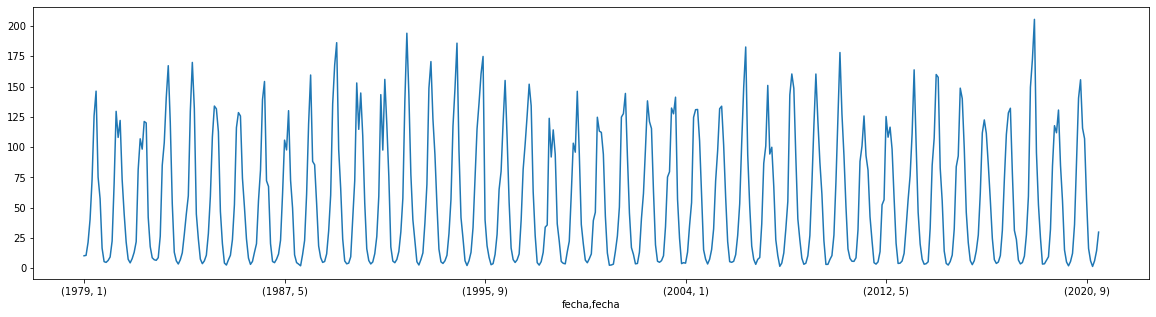

In [98]:
%matplotlib inline

bla = pev_df.set_index('fecha')
bla = bla[bla['basinid'] == 1]
bla = bla['val'].groupby(by=[bla.index.year, bla.index.month] ).apply(lambda x : sum([0 if i>0 else -i * 1000 for i in x]) )
bla.plot(figsize=(20,5))

In [94]:
bla

fecha  fecha
1      1979    -0.010136
       1980    -0.006289
       1981    -0.007291
       1982    -0.006143
       1983    -0.005607
                  ...   
12     2016    -0.000860
       2017    -0.001053
       2018    -0.001875
       2019     0.000969
       2020     0.000219
Name: val, Length: 507, dtype: float64

In [96]:
sum([1,2,3])

6